In [121]:
import os
import re
import pandas as pd

## Příprava dat

In [123]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [124]:
df = pd.read_parquet(os.path.join("data","cnb_ceska_proza.parquet"))
len(df)

47902

In [125]:
df = df.merge(pd.read_parquet(os.path.join("data","cnb_vyber.parquet")), left_index=True, right_index=True, how='inner')

In [126]:
len(df)

44251

In [127]:
df = df[df['rok'] >= 2019]

In [128]:
graf_rok_min = int(df['rok'].min())
graf_rok_min

2019

In [129]:
graf_rok_max = int(df['rok'].max())
graf_rok_max

2025

In [130]:
len(df)

8325

In [131]:
df = df.explode('020_a')

In [132]:
def isbn(x):
    try:
        if len(x.replace('-','')) == 13:
            return str(x.replace('-',''))
    except:
        pass

In [133]:
df['isbn'] = df['020_a'].apply(lambda x: isbn(x))

In [134]:
df[['020_a','isbn']].sample(20)

,020_a,isbn
001,,
nkc20233562372,978-80-908761-1-8,9788090876118
nkc20213301849,978-80-7530-276-2,9788075302762
nkc20203258735,978-80-270-8650-4,9788027086504
nkc20243625067,None,None
nkc20243588457,978-80-7612-691-6,9788076126916
nkc20233505465,978-80-267-2434-6,9788026724346
nkc20213353041,978-80-7252-876-9,9788072528769
nkc20193163409,978-80-266-1473-9,9788026614739
nkc20193163870,978-80-88320-15-9,9788088320159


In [135]:
odkud = "data_raw/ebooky"

In [136]:
stazene = set([x.split(".")[0] for x in os.listdir(odkud)])
len(stazene)

2858

In [137]:
df = df[df['isbn'].isin(stazene)]

In [138]:
df

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20193162052,2019.0,Čarodějnice,Vostrý Mirek,mzk2018995176,200120s2019 xr g 000 j cze,978-80-88318-05-7,None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32)]",[aut],mzk2018995176,"Vostrý, Mirek,",1968-,None,Čarodějnice /,Mirek Vostrý,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brandýs n/L :],"[Tofana,]",[2019],[1],[187 stran ;],None,[19 cm],None,None,[150 výtisků],None,None,None,None,None,None,None,None,None,"[české povídky, Czech short stories]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788088318057
nkc20193162055,2019.0,Ke Gogolovi a zpátky,Rollingerová-Riba Romana,jo20000075610,191127s2019 xr g 000 f cze,978-80-7487-279-2,"[Kč 299,00]",[(brožováno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],jo20000075610,"Rollingerová-Riba, Romana,",1971-,None,Ke Gogolovi a zpátky /,Romana Riba-Rollingerová,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Brumovicích :],"[Carpe diem,]",[2019],[1],[267 stran ;],None,[19 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788074872792
nkc20193161777,2019.0,Dobře zašitej frajer,Šabach Petr,jn19990201046,191211s2019 xr g 000 j cze,978-80-7637-070-8,"[Kč 399,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32), (082.21)]",[aut],jn19990201046,"Šabach, Petr,",1951-2017,None,Dobře zašitej frajer /,to nejlepší z Petra Šabacha uspořádali Emil Ha...,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Praze :],"[Paseka,]",[2019],[1],[333 stran ;],None,[23 cm],None,None,"[Údaj o vydání je chybný, správně má být: Vydá...",None,None,None,None,None,None,None,None,None,"[české povídky, české novely, výbory, Czech sh...","[edt, edt]","[jn20000400849, jn19990209335]","[Hakl, Emil,, Kahuda, Václav,]","[1958-, 1965-2023]",None,None,None,None,None,None,None,nam a22 i 4500,9788076370708
nkc20193158977,2019.0,Ukradená vražda,Češka Stanislav,xx0122614,191111s2019 xr g 000 f cze d,978-80-243-8914-1,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],xx0122614,"Češka, Stanislav,",1955-,None,Ukradená vražda :,Stanislav Češka,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2019],[1],[252 stran ;],None,[19 cm],"[Původní česká detektivka ;, Krimi]","[313. svazek, None]",None,None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,"[Původní česká detektivka, Krimi (MOBA)]",None,None,nam a22 i 4500,9788024389141
nkc20193158538,2019.0,Bezejmenní,Krčmář Milan,jo2012727454,191111s2019 xr h g 000 f cze,978-80-264-2789-6,"[Kč 449,00]","[(CPress ;, vázáno) :]",None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (=411.16), 314.151.3-054.73, 34...",[aut],jo2012727454,"Krčmář, Milan",None,None,Bezejmenní :,Milan Krčmář,None,None,None,[1. vydání],None,None,None,None,None,None,None,[V Brně :],"[CPress,]",[2019],[1],[479 stran :],[faksimile ;],[24 cm],None,None,"[V tiráži uvedeno nakladatelství: Edika, Termi...",None,None,"[1921-1930, 20. století, 1925]","[Židé, uprchlíci, vraždy, soudní procesy, Jews...",None,"[20. století, 20. století, 20. století, 1921-1...","[Polsko, Polsko, Česko, Česko, Poland, Poland,...","[Třebíč (Česko), Třebíč (Czechia)]",None,"[české román

In [139]:
autority = pd.read_parquet(os.path.join("data","aut_vyber.parquet"))

In [140]:
autority = autority.merge(pd.read_parquet(os.path.join('data','wikidata.parquet')), left_index=True, right_index=True, how="outer")

In [141]:
autority.sample(5)

,024_2,024_a_x,046_f,046_g,100_7,100_a,100_d,100_ind1,110_a,370_a,370_b,370_c,370_f,372_a,373_a,374_a,375_a,377_a,400_a,400_d,400_i,400_ind1,410_a,411_a,430_a,450_a,500_a,500_i,500_ind1,550_7,678_a,856_u,leader,024_a_y,ceny,druh_umrti,facebook,instagram,jazykove_verze,label_cs,label_en,manzelstvo,obcanstvi,partnerstvo,popis_cs,popis_en,potomstvo,pricina_umrti,profese,role,skoly,sourozenectvo,strany,twitter,udalosti,vezeni,w_gender,w_misto_narozeni,w_misto_umrti,w_narozeni,w_narozeni_presne,w_umrti,w_umrti_presne,web,wiki_cs,wiki_en
xx0101395,None,None,[1953],None,[xx0101395],"[Whiting, William Charles,]",[1953-],[1],None,None,None,None,None,None,None,None,None,None,"[Whiting, William C.,]",[1953-],None,[1],None,None,None,None,None,None,None,None,"[Americký vysokoškolský pedagog, zaměřený na b...",None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ntka173089,None,None,[1947],None,[ntka173089],"[Král, Jaromír,]",[1947-],[1],None,None,None,[Česko],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"[Publikace v oborech Inženýrské stavitelství, ...",None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ola2012714281,None,None,[1704],[1757],[ola2012714281],"[Trautson, Johann Joseph,]",[1704-1757],[1],None,None,None,None,None,None,None,None,None,None,"[Trautson von Falckenstein, Johann Joseph,, Tr...","[1704-1757, 1704-1757, 1704-1757, 1704-1757, 1...",None,"[1, 1, 0, 1, 1, 1]",None,None,None,None,None,None,None,None,"[Rakouský katolický duchovní, vídeňský arcibis...",None,cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
js2016936614,None,None,[1819],[1896],[js2016936614],"[Žiznevskij, Avgust Kazimirovič,]",[1819-1896],[1],None,None,"[Moskva, Rusko]",[Rusko],"[Tver‘, Rusko]","[archeologie, státní služba]",None,"[archeologové, státní úředníci]",[muž],[rus],None,None,None,None,None,None,None,None,None,None,None,None,"[Ruský archeolog, státní úředník.]",None,cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xx0282917,None,None,[1974],None,[xx0282917],"[Annecke, Thorsten,]",[1974-],[1],None,None,None,[Německo],None,"[anesteziologie, lékařství]",None,"[anesteziologové, lékaři]",[muž],[ger],None,None,None,None,None,None,None,None,None,None,None,None,[Německý anesteziolog.],None,cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
autority.columns

Index(['024_2', '024_a_x', '046_f', '046_g', '100_7', '100_a', '100_d',
       '100_ind1', '110_a', '370_a', '370_b', '370_c', '370_f', '372_a',
       '373_a', '374_a', '375_a', '377_a', '400_a', '400_d', '400_i',
       '400_ind1', '410_a', '411_a', '430_a', '450_a', '500_a', '500_i',
       '500_ind1', '550_7', '678_a', '856_u', 'leader', '024_a_y', 'ceny',
       'druh_umrti', 'facebook', 'instagram', 'jazykove_verze', 'label_cs',
       'label_en', 'manzelstvo', 'obcanstvi', 'partnerstvo', 'popis_cs',
       'popis_en', 'potomstvo', 'pricina_umrti', 'profese', 'role', 'skoly',
       'sourozenectvo', 'strany', 'twitter', 'udalosti', 'vezeni', 'w_gender',
       'w_misto_narozeni', 'w_misto_umrti', 'w_narozeni', 'w_narozeni_presne',
       'w_umrti', 'w_umrti_presne', 'web', 'wiki_cs', 'wiki_en'],
      dtype='object')

In [143]:
df = df.merge(autority[['w_gender','w_umrti','046_g','375_a']], left_on="autorstvo_kod", right_index=True, how="left")

In [144]:
df = df[(df['w_umrti'].isnull()) | (df['046_g'].isnull())]

In [145]:
df.sample(5)

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn,w_gender,w_umrti,046_g,375_a
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20223423055,2022.0,Pro oči nevidím,Horová Marie,xx0281963,220520s2022 xr g 000 f cze,978-80-279-0267-5,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],xx0281963,"Horová, Marie,",1977-,None,Pro oči nevidím /,Marie Horová,None,None,None,"[Druhé, upravené vydání, v nakladatelství MOBA...",None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2022],[1],[292 stran ;],None,[19 cm],"[Původní česká detektivka ;, Krimi]","[360. svazek, None]",None,None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,"[Původní česká detektivka, Krimi (MOBA)]",None,None,nam a22 i 4500,9788027902675,žena,NaN,None,[žena]
nkc20233545939,2023.0,Než zjistíš pravdu,Minářová Elena,xx0306174,230904s2023 xr g 000 f cze,978-80-7546-477-4,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4), (0:82-311.1)]",[aut],xx0306174,"Minářová, Elena,",1992-,None,Než zjistíš pravdu /,Elena Minářová,None,None,None,[První vydání],None,None,None,None,None,None,None,[Praha :],"[Fortuna Libri,]",[2023],[1],[239 stran ;],None,[22 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, thrillery (romány), psychologic...",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788075464774,žena,NaN,None,[žena]
nkc20223417687,2023.0,Boží potměšilost,Řehák Zdeněk,mzk2011642402,231130s2023 xr g 000 f cze,978-80-279-0485-3,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],mzk2011642402,"Řehák, Zdeněk,",1948-,None,Boží potměšilost /,Zdeněk Řehák,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2023],[1],[312 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788027904853,muž,NaN,None,None
nkc20233499754,2023.0,Vražedné předsudky,Mašková Eva,xx0273981,230406s2023 xr g 000 f cze,978-80-279-0801-1,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],xx0273981,"Mašková, Eva,",1958-,None,Vražedné předsudky /,Eva Mašková,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2023],[1],[269 stran ;],None,[19 cm],[Původní česká detektivka ;],[378. svazek],None,None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,[Původní česká detektivka],None,None,nam a22 i 4500,9788027908011,žena,NaN,None,[žena]
nkc20223473273,2022.0,Ztracen v zemi mamutů,Radosta Pavel,pna2008444809,221122t20222022xr a d 000 f cze,978-80-276-0414-2,None,[(vázáno)],None,None,None,None,"[821.162.3-3, 821-93]","[Česká próza, Literatura pro děti a mládež (be...","[821.162.3-31, 821-93, (0:82-311.3)]",[aut],pna2008444809,"Radosta, Pavel",None,None,Ztracen v zemi mamutů /,Pavel Radosta ; ilustrace Kateřina Coufalová,None,None,None,[První české vydání],None,None,None,None,None,None,None,"[Praha :, None]","[Slovart,, None]","[[2022], ©2022]","[1, 4]",[207 stran :],[barevné ilustrace ;],[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, dobrodružné romány, publikace p...",[ill],[ola20211115042],"[Coufalová, Kateřina]",None,None,None,None,None,None,None,None,nam a22 i 4500,9788027604142,muž,NaN,None,None


In [146]:
len(df)

1296

In [147]:
len(df[df['w_gender'].notnull()])

1098

In [148]:
def tri_gendery(trisedmpeta, gender_wikidata, autors):
    z = None
    if (str(autors).split(" ")[0][-1] == 'á'):
        z = 'á'
    else:
        z = 'neá'
    if gender_wikidata in (['muž','žena']):
        z = gender_wikidata
    try:
        for y in trisedmpeta:
            z = y
    except:
        pass
    return z

In [149]:
df['gender'] = df.apply(lambda row: tri_gendery(row['375_a'],row['w_gender'],row['autorstvo']), axis=1)

In [150]:
df[['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,
nkc20193162052,Vostrý Mirek,muž,[muž],muž
nkc20193162055,Rollingerová-Riba Romana,žena,None,žena
nkc20193158977,Češka Stanislav,muž,[muž],muž
nkc20193158538,Krčmář Milan,muž,None,muž
nkc20193158828,Vondruška Vlastimil,muž,[muž],muž
...,...,...,...,...
nkc20243606974,Jakoubková Alena,žena,[žena],žena
nkc20243606884,Rývorová Alžběta,NaN,[žena],žena
nkc20243607639,Sekerka Tomáš,muž,[muž],muž


In [151]:
df[df['gender'].isnull()][['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,


## Příprava knih

In [153]:
import simplemma

In [154]:
def remove_non_letters(input_string):
        # Define an empty string to store our result
        result_string = ''

        # Loop through each character in the given string
        for character in input_string:
            # If the character is a letter or whitespace
            if character.isalpha() or character.isspace():
                # Include it in our result string
                result_string += character

        # Return the cleaned string
        return result_string

In [155]:
ukazky = []
for i in df[df['gender'].notnull()]['isbn'].to_list():
    ukazka = {}
    ukazka['isbn'] = i
    with open(os.path.join(odkud, f"{i}.txt"), 'r', encoding='utf-8') as u:
        text = remove_non_letters(u.read().lower().strip().replace('\n',' ').replace('\t','').replace('\xa0',' '))
        slova = []
        ukazka['rozsah'] = len(text)
        for t in [t for t in text.split(' ') if len(t) > 2]:
            slova.append(simplemma.lemmatize(t, lang='cs'))
        ukazka['slova'] = set(slova)
        if len(set(slova)) > 50:
            ukazky.append(ukazka)

In [156]:
mz = pd.DataFrame(ukazky)
mz.sample(5)

,isbn,rozsah,slova
709,9788027904815,18111,"{vítat, zavrzání, zardi, podlaha, zavřený, výb..."
289,9788076335271,25583,"{nástupnictví, honit, nezvykle, srovnat, vítat..."
846,9788088483618,17494,"{nástěnný, patřit, mysl, rakovina, ten, pata, ..."
609,9788076373259,34854,"{nezvykle, vycházet, jednoduše, dopotácel, zah..."
323,9788076504110,64295,"{park, honit, našeptávač, hradčany, rabování, ..."


In [157]:
mz = mz.merge(df[['isbn','gender','autorstvo_kod']], left_on='isbn', right_on='isbn', how='left')

In [158]:
mz

,isbn,rozsah,slova,gender,autorstvo_kod
0,9788088318057,18416,"{vostrá, hradecký, vteřina, mysl, pata, ten, b...",muž,mzk2018995176
1,9788074872792,20802,"{záklaďácké, hradčany, spravedlivý, ambice, ví...",žena,jo20000075610
2,9788024389141,16962,"{konejšit, honit, patřit, dlouhodoba, věnovat,...",muž,xx0122614
3,9788026427896,110563,"{ultimáta, nenudila, zabalit, belgrad, spraved...",muž,jo2012727454
4,9788024389059,20745,"{spravedlivý, srovnat, včera, šenky, nenávist,...",muž,xx0004129
...,...,...,...,...,...
1263,9788075886170,16377,"{políbení, stoprocentní, patřit, končetina, te...",muž,jk01082907
1264,9788076951822,33056,"{nemíním, kladivo, peugeot, zabalit, sypaná, p...",muž,jo2006362253
1265,9788027913282,24751,"{vycházet, ukradený, včera, slušně, autíčku, n...",žena,mzk2002102588
1266,9788075886217,50270,"{honit, peugeot, kaleidoskop, vycházet, srovna...",muž,xx0251298


## Základní statistiky

In [160]:
len(mz[mz['gender'] == 'muž'])

564

In [161]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()

346

In [162]:
len(mz[mz['gender'] == 'žena'])

661

In [163]:
mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

418

In [164]:
mz = mz.drop_duplicates(subset=['autorstvo_kod'], keep="last")

Rozsah zkoumaného textu v NS:

In [166]:
mz['rozsah'].sum() / 1800

12364.989444444445

In [167]:
graf_rozsah = int((mz['rozsah'].sum() / 1800 / 1000).round())
graf_rozsah

12

In [168]:
graf_muzi = mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()
graf_muzi

346

In [169]:
graf_zeny = mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()
graf_zeny

418

Velikost vzorku celkem:

In [171]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique() +mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

764

In [172]:
mz_slova = mz.explode('slova')

In [173]:
kolik = mz_slova.groupby("slova").size()

In [174]:
kolik.quantile([0.01, 0.02, 0.1, 0.5, 0.75, 0.9, 0.99, 0.999])

0.010      1.000
0.020      1.000
0.100      1.000
0.500      1.000
0.750      3.000
0.900     10.000
0.990    151.000
0.999    614.324
dtype: float64

In [175]:
kolik

slova
Abraham      4
Abrahám      4
Achilles     1
Adam        61
Adamec       2
            ..
שקרן         1
 září        1
  pátek      1
 který       1
 patro       1
Length: 151677, dtype: int64

In [176]:
hranice = int(kolik.quantile(0.97))
hranice

48

In [177]:
mz_vyfiltrovana = kolik[kolik >= hranice].index.to_list()

In [178]:
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]

In [179]:
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()

In [180]:
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()

In [181]:
pomer = m / z

In [182]:
pomer.sample(10)

slova
cizinec      1.208092
oběť         1.403519
inspirace    1.208092
snímek       1.254558
člověk       1.016862
vysoká       0.848541
nyní         1.320998
široký       0.959854
papírový     0.966474
vločka       0.710643
dtype: float64

## Všechna slova bez filtru

In [184]:
z2 = mz[mz['gender'] == 'žena'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m2 = mz[mz['gender'] == 'muž'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()

In [185]:
pomer_vsech = m2 / z2

In [186]:
pomer_vsech.dropna().sort_values().head(20)

slova
sedávat        0.067116
protočila      0.067116
davidovi       0.075506
nebolelo       0.086292
zamumlá        0.086292
nezeptala      0.086292
stesk          0.086292
Gabriel        0.086292
cpala          0.086292
upila          0.086292
převalovala    0.086292
dojíždět       0.092930
otrávená       0.092930
poskládaný     0.092930
vstávala       0.092930
hřebínek       0.092930
mělas          0.092930
zasměju        0.092930
uchechtne      0.100674
vycestovat     0.100674
dtype: float64

In [187]:
pomer_vsech[pomer_vsech.index == 'erekce']

slova
erekce    9.66474
dtype: float64

In [188]:
pomer_vsech[pomer_vsech.index == 'sex']

slova
sex    0.919593
dtype: float64

In [189]:
pomer_vsech[pomer_vsech.index == 'porno']

slova
porno    3.422929
dtype: float64

In [190]:
pomer_vsech[pomer_vsech.index == 'vagína']

slova
vagína    1.812139
dtype: float64

In [191]:
pomer_vsech[pomer_vsech.index == 'penis']

slova
penis    1.065964
dtype: float64

In [192]:
pomer_vsech[pomer_vsech.index == 'fousy']

slova
fousy    1.812139
dtype: float64

In [193]:
pomer_vsech[pomer_vsech.index == 'chlup']

slova
chlup    0.542409
dtype: float64

In [194]:
pomer_vsech[pomer_vsech.index == 'nádor']

slova
nádor    1.61079
dtype: float64

In [195]:
pomer_vsech[pomer_vsech.index == 'fotbal']

slova
fotbal    1.858604
dtype: float64

In [196]:
pomer_vsech[pomer_vsech.index == 'hokej']

slova
hokej    1.476557
dtype: float64

In [197]:
pomer_vsech[pomer_vsech.index == 'rallye']

slova
rallye    1.208092
dtype: float64

In [198]:
pomer_vsech[pomer_vsech.index == 'Krkonoše']

slova
Krkonoše    1.057081
dtype: float64

In [199]:
pomer_vsech[pomer_vsech.index == 'Šumava']

slova
Šumava    1.359104
dtype: float64

In [200]:
pomer_vsech[pomer_vsech.index == 'Říp']

slova
Říp    1.208092
dtype: float64

## Celkový pohled

In [202]:
muzi = mz_filtr[mz_filtr['gender'] == 'muž']['autorstvo_kod'].to_list()
', '.join(sorted((df[df['autorstvo_kod'].isin(muzi)]['autorstvo'].drop_duplicates().to_list())))

'Ajvaz Michal, Balda David, Balák Libor, Banga Patrik, Bareš Pavel, Bauer Jan, Bazger Petr, Beran Ladislav, Beran Stanislav, Bernatský Vojtěch, Bečan Martin, Birdman Shigor, Blaho Ondřej, Boubín Dalibor, Boček Evžen, Boček Lukáš, Brož Petr, Budai David, Buddeus Ondřej, Bureš Roman, Bálek Jaroslav, Bárta Václav, Bílek Petr, Bým Petr, Březina Jiří, Březina Michal, Chadima Martin, Csicsely Lukáš, Ctibor Pavel, Cubeca Karel, Cílek Roman, Dadák Matěj, Decimus Erik, Denk Petr, Ditrych Břetislav, Diviš Aleš, Dobrylovský Jiří, Dobrý Marek, Dostál Aleš, Dotlačil Jakub, Doucha Josef, Dočekal Boris, Drbohlav Jan, Drescher Alex, Duda Jan, Dutka Edgar, Dvořák Marek, Dědič Jiří, Eidler Petr, Epstein Marek, Erml Richard, Fahrner Martin, Fanta Ondřej, Fibich Ondřej, Fišer Lukáš, Fišer Martin, Folný Jan, Fousek Josef, Fránek Jakub, Fuchs Oskar, Fíla Ivan, Galambica Ivan, Gardner Jan, Gdovín Vladimír Adam, Glockner David, Goffa Martin, Grant Jiří, Gravensteen A., Green Scum, Gris Daniel, Grmolec Zdeněk,

In [203]:
zeny = mz_filtr[mz_filtr['gender'] == 'žena']['autorstvo_kod'].drop_duplicates().to_list()
', '.join(sorted(df[df['autorstvo_kod'].isin(zeny)]['autorstvo'].drop_duplicates().to_list()))

'Abrahámová Martina, Addicks Lucie, Ambrožová Dorota, An Elen, Andrlová Šárka, Auzká Lucie, Aycox Klára, Babišová Martina, Bartošová Tereza, Basiková Anna, Basiková Bára, Baštanová Petra, Bechynková Lucie, Bellová Bianca, Bendová Karolína, Beranová Dana, Bernášková Jana, Blahová Miriam, Blanářová Alena, Blažková Kateřina, Bohatá Simona, Boho Michaela, Bolavá Anna, Bolfová Markéta, Borlová Julie, Boučková Martina, Boučková Tereza, Brabcová Kateřina, Braunová Petra, Brányiková Katarína, Bublanová Alžběta, Burgerová Kristýna, Bártová Anna Beatrix, Bílková Alžběta, Camille G, Chalupníková Kateřina, Chalupová Lenka, Chaya Lucie, Chlubnová Lenka, Cima Anna, Ciprová Oldřiška, Coufalová Valentýna, Czastková Klára, Damijo Alena, Dancingerová Marta, Denemarková Radka, Denková Melita, Devátá Ivanka, Divišová Anna, Dobiášová Tereza, Dobrovolná Ilona, Dolejšová Eva, Domská Marie, Donátová Uljana, Dopitová Michaela, Dostálová Zuzana, Dousková Irena, Drdlová Helena, Dubská Kateřina, Dusová Tereza, Du

In [204]:
len(pomer)

4631

<Axes: ylabel='Frequency'>

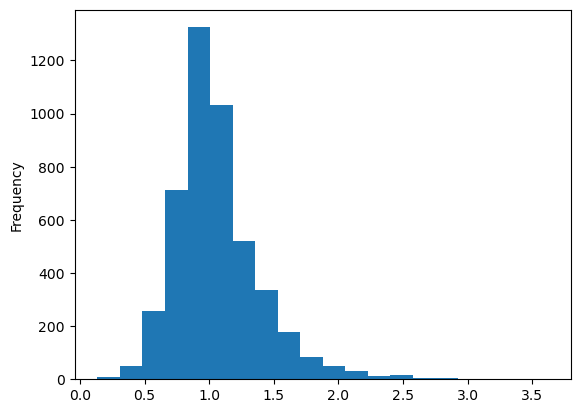

In [205]:
pomer.plot.hist(bins=20)

In [206]:
neutralita = pd.DataFrame(pomer).rename(columns={0:'cetnost'})
neutralita['odchylka'] = neutralita['cetnost'].apply(lambda x: x-1 if x>1 else 1-x)
neutralita.sort_values(by='odchylka').head(60)

,cetnost,odchylka
slova,,
být,1.000000,0.000000
když,1.000000,0.000000
jako,1.000000,0.000000
ale,1.000000,0.000000
rozhovor,1.000077,0.000077
podlaha,1.000077,0.000077
dělat,0.999909,0.000091
zlý,0.999801,0.000199
prasit,0.999801,0.000199


## Slova více používaná muži-spisovateli

In [208]:
pomer.sort_values(ascending=False).head(25)

slova
pistole       3.624277
prezident     3.624277
ruský         3.052023
kladivo       2.818882
politik       2.778613
nepříliš      2.771506
velet         2.761354
příkop        2.761354
kulka         2.738343
vůl           2.718208
západní       2.657803
technický     2.635838
souboj        2.606936
kapitán       2.588770
ohrozit       2.558313
vývoj         2.536994
střílet       2.526012
válečný       2.516859
smrtelný      2.512832
zvláště       2.483301
riziko        2.476590
civilizace    2.471098
zápas         2.460929
vesta         2.416185
isbn          2.416185
dtype: float64

In [209]:
pomer[pomer.index.str.endswith('la')].sort_values()

slova
netušila         0.214772
zahlédla         0.247814
nečekala         0.249289
neuměla          0.265780
lekla            0.271821
užívala          0.288892
rozhlížela       0.302023
ucítila          0.319789
nestihla         0.334153
ptala            0.362428
četla            0.367165
vyhrkla          0.385561
chystala         0.395754
přejela          0.409523
zadívala         0.422832
chytla           0.429544
nalila           0.441985
nešla            0.443789
zkontrolovala    0.448720
nechávala        0.449523
strčila          0.462674
neřekla          0.463712
sklopila         0.464651
usmívala         0.474608
zamávala         0.483237
ušklíbla         0.483237
odložila         0.514082
vzdychla         0.517754
mávla            0.531561
vyrazila         0.535012
zasmála          0.540462
odsekla          0.589313
odvětila         0.591194
nepřišla         0.632810
zažila           0.637604
přikývla         0.645231
jezdila          0.690339
pohladila        0.752209
dokola

## Slova více používaná ženami-spisovatelkami

Pleso vypadá spíš jako špatné lemma slova ples.

In [212]:
(1 / pomer).sort_values(ascending=False).head(25)

slova
babi           7.449761
netušila       4.656100
zahlédla       4.035287
nečekala       4.011410
neuměla        3.762505
lekla          3.678894
užívala        3.461505
pyžamo         3.386255
rozhlížela     3.311005
salát          3.145455
ucítila        3.127060
nestihla       2.992639
povytáhnout    2.934754
spěšně         2.859504
miminko        2.859504
objímat        2.855742
kamarádka      2.832749
koláč          2.801619
ptala          2.759171
četla          2.723568
mamka          2.719754
příšerně       2.660629
vyhrkla        2.593620
rande          2.580636
navrch         2.542379
dtype: float64

## Graf

In [214]:
pomer_vsech.sample(20)

slova
kysnutí               NaN
neozvalo         3.624277
slovíčku              NaN
justice               NaN
pseudosvět            NaN
soucitněji            NaN
srdíčku          0.805395
névím                 NaN
polní            2.243600
jugoše                NaN
pověřený        10.872832
cholerické       0.604046
dumourieze            NaN
podlaha          1.000077
drátkách         2.416185
posoutěžních          NaN
zadusit               NaN
dozpívala        0.604046
nepohybovali          NaN
penzionované          NaN
dtype: float64

In [215]:
pomer.reset_index()

,slova,0
0,Adam,1.094834
1,Amerika,1.294385
2,Anglie,1.115162
3,Anna,1.067617
4,Brno,0.979534
...,...,...
4626,žádost,1.427746
4627,žák,1.359104
4628,žíla,1.362317
4629,žít,0.888597


In [216]:
import polars as pl

In [217]:
problematicke = ['pleso','Karlov','podpatku']
pomer2 = pomer.reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})
pomer2 = pomer2[~pomer2['slovo'].isin(problematicke)]
pomer2 = pomer2.groupby('slovo')['rozdíl'].first()
do_grafu = pd.concat([
    (1 / pomer).sort_values(ascending=False).head(12),
    -pomer.sort_values(ascending=False).head(12)
]).sort_values(ascending=False).reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})
do_grafu['mz'] = do_grafu['rozdíl'].apply(lambda x: 'mužští autoři' if x < 0 else 'ženské autorky')
do_grafu

,slovo,rozdíl,mz
0,babi,7.449761,ženské autorky
1,netušila,4.656100,ženské autorky
2,zahlédla,4.035287,ženské autorky
3,nečekala,4.011410,ženské autorky
4,neuměla,3.762505,ženské autorky
5,lekla,3.678894,ženské autorky
6,užívala,3.461505,ženské autorky
7,pyžamo,3.386255,ženské autorky
8,rozhlížela,3.311005,ženské autorky
9,salát,3.145455,ženské autorky


In [218]:
do_grafu2 = do_grafu
do_grafu2['rozdíl'] = do_grafu2['rozdíl'].apply(lambda x: abs(x))
do_grafu2

,slovo,rozdíl,mz
0,babi,7.449761,ženské autorky
1,netušila,4.656100,ženské autorky
2,zahlédla,4.035287,ženské autorky
3,nečekala,4.011410,ženské autorky
4,neuměla,3.762505,ženské autorky
5,lekla,3.678894,ženské autorky
6,užívala,3.461505,ženské autorky
7,pyžamo,3.386255,ženské autorky
8,rozhlížela,3.311005,ženské autorky
9,salát,3.145455,ženské autorky


In [219]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [220]:
def irozhlas_conf():

    return {
        "config" : {
             "title": {'font': "Noticia Text",
                      'fontSize': 14,
                      'anchor': 'start',
                       'fontWeight': 'bolder',
                    'subtitleFont': 'Noticia Text',
                      'subtitleFontSize': 12,
                       'subtitleFontWeight': 'lighter',
                      'subtitlePadding': 12,
                       'dy': -12,
                      },
             "axis": {
                "labelFont": "Asap",
                "titleFont": "Asap",
                 "fontWeight": "lighter",
                "titleFontWeight": "lighter",
                "labelFontSize": 10,
                "titleFontSize": 10,
                'labelPadding': 2,
                 'titlePadding': 10
            },
            "legend": {
                "labelFont": "Asap",
                "labelFontWeight": "normal",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 10,
                "titleFontSize": 10
            }
        }
    }

alt.themes.register('irozhlas', irozhlas_conf)
alt.themes.enable('irozhlas')

ThemeRegistry.enable('irozhlas')

In [221]:
from textwrap import wrap


In [222]:
titulek = ["Slova používaná častěji spisovatelkami a spisovateli"]
kredit = "zdroj dat: Česká národní bibliografie · vizualizace: iROZHLAS.cz · 2025"
podtitulek = f"Graf srovnává pouze slova, která se objevila alespoň v {hranice} knihách, vypadla tak například „erekce“, 9× častěji zmiňovaná muži. Do výsledku se nepromítá, zda se v ukázce slovo objevilo jednou, nebo víckrát."
podtitulek = wrap(podtitulek, 70)
info = [f"zdroj: {graf_rozsah} tisíc stran ukázek z próz {graf_zeny} českých autorek a {graf_muzi} autorů z let {graf_rok_min} a {graf_rok_max}", "data: Česká národní bibliografie, martinus.cz · vizualizace: iROZHLAS.cz · 2025"]

In [223]:
max_abs_value = max(abs(do_grafu['rozdíl'].max()), abs(do_grafu['rozdíl'].min()))

mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))

)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [326]:
# Chart for "mužští autoři"
muzsti_autori = alt.Chart(
    do_grafu2[do_grafu2["mz"] == "mužští autoři"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4'])),
).properties(title={"text": "mužští autoři", 'fontSize': 12}, width=120)

# Chart for "ženské autorky"
zenske_autorky = alt.Chart(
    do_grafu2[do_grafu2["mz"] == "ženské autorky"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#E7666E'])),
).properties(title={"text": "ženské autorky", 'fontSize': 12}, width=120)

# Combine the charts with shared x-axis scale and original title
mz_graf = alt.hconcat(
    zenske_autorky,
    muzsti_autori
).resolve_scale(
    x='shared',  # Ensures the x-axes share the same scale
    color='independent'  # Allows each chart to use its own color encoding
).properties(
    title={
        'text': titulek,
        'subtitle': podtitulek
    }
)

mz_graf.configure_view(stroke='transparent')

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.

alt.HConcatChart(...)

In [225]:
def me_to_neurazi(zaklad_grafu, soubor, kredity):

    os.makedirs("grafy", exist_ok=True)
    
    credits = pl.DataFrame({'text': [kredity]})
    credits = alt.Chart(credits.to_pandas()).encode(text=alt.Text('text:N')).mark_text(fontSize=10,font="Asap", baseline='line-bottom', align='right').properties(width=300)
    combined_chart = alt.vconcat(zaklad_grafu, credits).properties(background='cyan')

    combined_chart.save(os.path.join("grafy",f"{soubor}.svg"))
    combined_chart.save(os.path.join("grafy",f"{soubor}.png"), ppi=400)
    
    return combined_chart

In [226]:
def me_to_neurazi(zaklad_grafu, soubor, kredity):
    os.makedirs("grafy", exist_ok=True)

    credits = pl.DataFrame({'text': [kredity]})
    credits = alt.Chart(credits.to_pandas()).encode(
        text=alt.Text('text:N')
    ).mark_text(
        fontSize=10,
        font="Asap",
        baseline='line-bottom',
        align='right',
        dx=190  # Adjust dx to move the text to the right edge
    ).properties(width=300)

    combined_chart = alt.vconcat(zaklad_grafu, credits) # .properties(background='cyan')

    combined_chart.save(os.path.join("grafy", f"{soubor}.svg"))
    combined_chart.save(os.path.join("grafy", f"{soubor}.png"), ppi=400)

    return combined_chart

In [227]:
me_to_neurazi(mz_graf, "muzska_zenska_slova", info)

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.

alt.VConcatChart(...)